referencing:

https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d


In [1]:
%env AWS_ACCESS_KEY_ID=""
%env AWS_SECRET_ACCESS_KEY_ID=""
%env AWS_REGION_NAME=""
%env AWS_BUCKET_NAME=""

%env MODEL_VERSION=1

env: AWS_ACCESS_KEY_ID=""
env: AWS_SECRET_ACCESS_KEY_ID=""
env: AWS_REGION_NAME=""
env: AWS_BUCKET_NAME=""
env: MODEL_VERSION=1


In [2]:
# cmd to check gpu process
!nvidia-smi

Sun Sep 11 09:13:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 25.8 MB/s 


In [4]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 26.4 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 1.3 MB 57.3 MB/s 
     |████████████████████████████████| 238 kB 74.3 MB/s 
     |████████████████████████████████| 352 kB 74.4 MB/s 
     |████████████████████████████████| 116 kB 75.3 MB/s 
     |████████████████████████████████| 99 kB 10.9 MB/s 
     |████████████████████████████████| 1.1 MB 62.4 MB/s 


In [5]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 30.1 MB/s 
     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 9.1 MB 64.9 MB/s 
     |████████████████████████████████| 140 kB 59.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


In [6]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [7]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [8]:
import pandas as pd

data = pd.read_csv('../gdrive/MyDrive/bert-chatbot/sample.csv')

data = data[data['intent']!='FALLBACK']
data = data[data['intent']!='FORBIDDEN']
data = data[~data['intent'].str.startswith("OTHERS_")]

df = pd.DataFrame(data)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['intent'])

num_of_classes = len(le.classes_)

from sklearn.model_selection import train_test_split
y = tf.keras.utils.to_categorical(le.transform(df["intent"]))
x_train, x_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.25)


print(len(df))
print(le.classes_)
df

1638
['ADDRESS' 'AGE' 'APPRAISAL_BAD' 'APPRAISAL_COMPLAIN' 'APPRAISAL_GOOD'
 'APPRAISAL_LIKE_BOT' 'APPRAISAL_THANK_YOU' 'ASK_FOR_HELP'
 'ASK_FOR_REAL_PERSON' 'BOT_FUNCTIONS' 'BOT_NAME' 'BOT_NOT_UNDERSTAND'
 'CHITCHAT' 'GENDER' 'GREETINGS' 'GREETINGS_BYE' 'INAPPROPRIATE_ACTION'
 'INVESTMENT' 'OFFICE_HOUR' 'USER_EMOTIONS' 'USER_NOT_UNDERSTAND']


,intent,text
0,GENDER,Are you woman
1,GENDER,are you a boy?
2,GENDER,Are you female
3,GENDER,想知你係男定係女?
4,GENDER,你係咪女仔？
...,...,...
5926,INVESTMENT,琴日入完tqqq 今日即跌
5927,INVESTMENT,熊軍會戰勝歸來
5928,INVESTMENT,有時燈呢家野 真係唔到自己唔信
5929,INVESTMENT,今晚呢啲時候真係唔係入貨嘅時間，上落太大


In [9]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"

# only chinese model
#tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4"
#tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_zh_preprocess/3"


print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [10]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [11]:
text_test = ['apple a p p l e']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 72894 10284   169   184   184   180   173   102     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
def build_classifier_model():
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  encoder_inputs = preprocessing_layer(text_input)
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [26]:
# custom sequence length
"""
def build_classifier_model():
  preprocessor = hub.load(tfhub_handle_preprocess)
  text_input = [tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')]
  tokenize = hub.KerasLayer(preprocessor.tokenize)
  tokenized_inputs = [tokenize(segment) for segment in text_input]
  seq_length = 80  # Your choice here.
  bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length), name='preprocessing') 
  encoder_inputs = bert_pack_inputs(tokenized_inputs)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  #net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)
"""

"\ndef build_classifier_model():\n  preprocessor = hub.load(tfhub_handle_preprocess)\n  text_input = [tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')]\n  tokenize = hub.KerasLayer(preprocessor.tokenize)\n  tokenized_inputs = [tokenize(segment) for segment in text_input]\n  seq_length = 80  # Your choice here.\n  bert_pack_inputs = hub.KerasLayer(\n    preprocessor.bert_pack_inputs,\n    arguments=dict(seq_length=seq_length), name='preprocessing') \n  encoder_inputs = bert_pack_inputs(tokenized_inputs)\n  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  #net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)\n  return tf.keras.Model(text_input, net)\n"

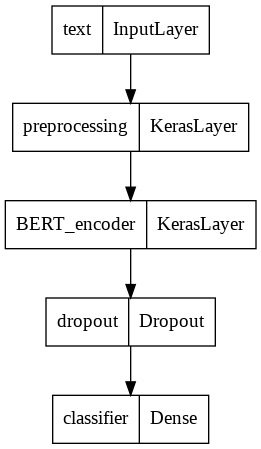

In [14]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)


In [15]:
classifier_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [17]:
"""
epochs = 5
steps_per_epoch = num_of_classes
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
print(steps_per_epoch)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,                                          
                                          optimizer_type='adamw')
"""

"epochs = 5\nsteps_per_epoch = num_of_classes\nnum_train_steps = steps_per_epoch * epochs\nnum_warmup_steps = int(0.1*num_train_steps)\nprint(steps_per_epoch)\n\ninit_lr = 3e-5\noptimizer = optimization.create_optimizer(init_lr=init_lr,\n                                          num_train_steps=num_train_steps,\n                                          num_warmup_steps=num_warmup_steps,                                          \n                                          optimizer_type='adamw')"

In [18]:
from tensorflow.keras.optimizers import Adam
classifier_model.compile(Adam(learning_rate=3e-5), loss = "categorical_crossentropy", metrics = ["accuracy"]) # learning_rate recommand from the paper
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [19]:
n_epochs = 5

model_fit = classifier_model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test))

Epoch 1/5
39/39 [==============================] - 51s 923ms/step - loss: 2.6593 - accuracy: 0.2443 - val_loss: 2.0367 - val_accuracy: 0.4732
Epoch 2/5
39/39 [==============================] - 36s 929ms/step - loss: 1.6882 - accuracy: 0.5065 - val_loss: 1.2693 - val_accuracy: 0.6561
Epoch 3/5
39/39 [==============================] - 36s 933ms/step - loss: 0.9558 - accuracy: 0.7622 - val_loss: 0.8750 - val_accuracy: 0.7512
Epoch 4/5
39/39 [==============================] - 36s 937ms/step - loss: 0.5736 - accuracy: 0.8518 - val_loss: 0.7307 - val_accuracy: 0.7854
Epoch 5/5
39/39 [==============================] - 37s 944ms/step - loss: 0.3315 - accuracy: 0.9275 - val_loss: 0.5974 - val_accuracy: 0.8293


In [20]:
import numpy as np
pred = classifier_model.predict(["tu es un garçon?"])

top_n_indices = pred[0].argsort()[-5:][::-1]
top_n_indices


array([13,  1, 10, 12, 19])

In [21]:
for label, score in zip(le.classes_[top_n_indices], pred[0][top_n_indices]):
  print(str(label) + " "+ str(score))


GENDER 0.52323866
AGE 0.31136435
BOT_NAME 0.042386647
CHITCHAT 0.03817015
USER_EMOTIONS 0.012815372


In [22]:
import json

f = open('../gdrive/MyDrive/bert-chatbot/reply.json')
response = json.load(f)
print(response['GENDER'])

[{'en': "I don't know my gender yet, but I was created by a male developer.", 'zh': '我仲未知我係男定女，但我嘅開發者係男人嚟。', 'fr': 'Je ne sais pas encore, mais mon développeur est un homme.'}]


In [23]:
lang = 'en'
query = ["你好!", "hello", "琴日入完tqqq 今日即跌", "你辦公時間是甚麼?", "you perform bad"]

predictions = classifier_model.predict(query)
for i, pred in enumerate(predictions):
  predictedIntent = le.classes_[pred.argsort()[::-1][0]]
  print("Query: {}".format(query[i]))
  print("Response: {}".format(response.get(predictedIntent)[0][lang]))

Query: 你好!
Response: I don't have feeling actually, maybe some more advanced chatbot can have their own feeling?
Query: hello
Response: Hi, how is your day?
Query: 琴日入完tqqq 今日即跌
Response: I lost a lot on stock, sooner I won't even have money to pay the rent cost on AWS EC2... which means you may not reach me later.
Query: 你辦公時間是甚麼?
Response: As long as the server keeps running, I work 7/24. So just reach me anytime you are free.
Query: you perform bad
Response: Sorry sorry, I know I am not smart enough. Maybe I will improve in the future with more training data.


In [24]:
# copy model to drive
export_dir='./saved_model/'
model_version = os.getenv("MODEL_VERSION")
tf.saved_model.save(classifier_model, export_dir=export_dir)
%cp -av /content/saved_model /gdrive/MyDrive/bert-chatbot/model/{model_version}

'/content/saved_model' -> '/gdrive/MyDrive/bert-chatbot/model/1'
'/content/saved_model/saved_model.pb' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model.pb'
'/content/saved_model/variables' -> '/gdrive/MyDrive/bert-chatbot/model/1/variables'
'/content/saved_model/variables/variables.index' -> '/gdrive/MyDrive/bert-chatbot/model/1/variables/variables.index'
'/content/saved_model/variables/variables.data-00000-of-00001' -> '/gdrive/MyDrive/bert-chatbot/model/1/variables/variables.data-00000-of-00001'
'/content/saved_model/assets' -> '/gdrive/MyDrive/bert-chatbot/model/1/assets'
'/content/saved_model/assets/vocab.txt' -> '/gdrive/MyDrive/bert-chatbot/model/1/assets/vocab.txt'


In [25]:
'''
import boto3

session = boto3.Session(
    aws_access_key_id= os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY_ID"),
    region_name=os.getenv("AWS_REGION_NAME")
)
s3 = session.resource('s3')
bucket = s3.Bucket(os.getenv("AWS_BUCKET_NAME"))


path = "./saved_model"
for subdir, dirs, files in os.walk(path):
    for file in files:
        full_path = os.path.join(subdir, file)
        with open(full_path, 'rb') as data:
            bucket.put_object(Key="saved_model_bert/" + os.getenv("MODEL_VERSION") + "/" + full_path[len(path)+1:], Body=data)
'''

'\nimport boto3\n\nsession = boto3.Session(\n    aws_access_key_id= os.getenv("AWS_ACCESS_KEY_ID"),\n    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY_ID"),\n    region_name=os.getenv("AWS_REGION_NAME")\n)\ns3 = session.resource(\'s3\')\nbucket = s3.Bucket(os.getenv("AWS_BUCKET_NAME"))\n\n\npath = "./saved_model"\nfor subdir, dirs, files in os.walk(path):\n    for file in files:\n        full_path = os.path.join(subdir, file)\n        with open(full_path, \'rb\') as data:\n            bucket.put_object(Key="saved_model_bert/" + os.getenv("MODEL_VERSION") + "/" + full_path[len(path)+1:], Body=data)\n'